In [46]:
#%pip  install litellm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Optional: ensure deps (uncomment if needed)
# %pip install -q langgraph langchain-ollama duckdb pandas pyarrow matplotlib langchain-ollama

from Agent.data_agent import SalesDataAgent

# Initialize the agent (uses default data path: data/Store_Sales_Price_Elasticity_Promotions_Data.parquet)
agent = SalesDataAgent(
    model="llama3.2:3b",       # requires Ollama running locally with this model pulled
    temperature=0.1,
    max_tokens=2000,
    streaming=True
)


In [48]:
agent.check_model()

Server is running locally
Ollama is running locally


True

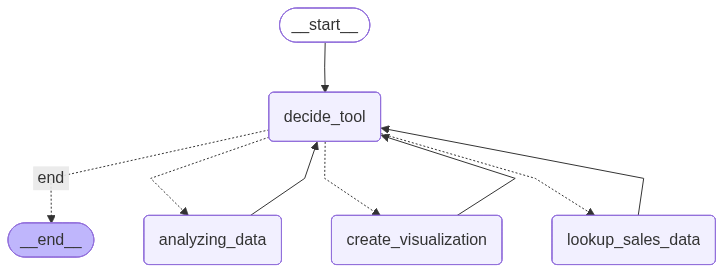

''

In [49]:
agent.draw_graph()

In [50]:
from Agent.data_agent import SalesDataAgent

agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model="llama3.2:3b"
)
#ret = agent.run("What was the most popular product SKU?")
#print(ret.get("answer"))

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: evaluating-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [51]:
import json
import os

import csv
from typing import Dict, List, Tuple

In [52]:
def text_to_csv(text: str) -> List[List[str]]:
    """Convert text table to CSV rows.
    
    Handles both space-separated and pipe-separated formats.
    """
    lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
    if not lines:
        return []
    
    rows = []
    for line in lines:
        # Try splitting by multiple spaces first
        if '  ' in line:
            parts = [p.strip() for p in line.split() if p.strip()]
        # Try pipe separator
        elif '|' in line:
            parts = [p.strip() for p in line.split('|') if p.strip()]
        # Fallback to comma
        else:
            parts = [p.strip() for p in line.split(',') if p.strip()]
        
        if parts:
            rows.append(parts)
    
    return rows

def save_csv(rows: List[List[str]], filepath: str):
    """Save rows to CSV file."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(rows)


In [ ]:
PREFIX = 'gpt'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

for i in range(len(dataset)):
    if (dataset[i].get('gen_sql') and dataset[i].get('gen_data')):
        print(f'\nSkipping question {i+1}/{len(dataset)} as generated results were already added.')
        continue
    ret = agent.run(dataset[i]['prompt'])
    dataset[i]['gen_sql']=ret['sql_query']
    dataset[i]['gen_data']=ret['data']
    csv_path = f"evaluation/csv_queries/{PREFIX}_{i}_gen.csv"
    result_rows = text_to_csv(ret['data'])
    save_csv(result_rows, csv_path)
    dataset[i]["gen_csv_path"]=csv_path

with open(DATASET_FILE_PATH, 'w') as f:
    json.dump(dataset, f, indent=2)

Running the graph...
[LangGraph] Starting LangGraph execution with tracing
Tool selected: lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, SUM(Total_Sale_Value) AS total_revenue, SUM(Qty_Sold) AS total_units, AVG(Total_Sale_Value / Qty_Sold) AS avg_unit_price FROM sales WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2023%' GROUP BY SKU_Coded ORDER BY total_revenue DESC LIMIT 10
Tool selected: analyzing_data
Data to analyze:
  SKU_Coded  total_revenue  total_units  avg_unit_price
   6200700  353964.937498      36081.0        9.867944
   6184900  147797.616945       1651.0       89.506564
   6194250  116109.579178       5824.0       19.925815
   6200650   83765.828704       8405.0        9.962051
   6191400   70791.602219       1581.0       46.345648
   6184100   67589.119407       3396.0       19.895433
   6186250   66756.588099        960.0       69.514207
   6176200   60119.691723       1086.0       55.366948
   6199250   57957.061886       1273.0       46.638724
   6179250   54660.

In [6]:
from tqdm import tqdm

agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What was the average transaction value?",
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = agent.run(question)
        print("\nQ:", question)
        if ret.get("error"):
            print("Error:", ret["error"])
            continue
        answer = ret.get("answer", [])
        if answer:
            print("Analysis:\n", answer[0])
            if len(answer) > 1:
                print("\nChart code:\n", answer[1])
        else:
            print("No answer returned.")
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

Processing questions:   0%|          | 0/5 [00:00<?, ?it/s]

Running the graph...
[LangGraph] Starting LangGraph execution with tracing


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

Tool selected: lookup_sales_data


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

Generated SQL Query:
 SELECT SKU_Coded FROM sales GROUP BY SKU_Coded ORDER BY SUM(Total_Sale_Value) DESC LIMIT 1


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

Tool selected: analyzing_data
Data to analyze:
  SKU_Coded
   6200700


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

Tool selected: create_visualization


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

Este es el chart config: {'chart_type': 'bar', 'x_axis': 'SKU_Coded', 'y_axis': '', 'title': 'Most Popular Product SKU', 'data': ' SKU_Coded\n   6200700'}


Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/simop/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.req

KeyboardInterrupt: 

In [ ]:
from langchain.globals import set_verbose
from langchain.globals import set_debug

set_debug(False)
set_verbose(False)

In [ ]:
#result = agent.run("Show me the sales in Nov 2021")
input_state = {"prompt": "Show me the sales in Nov 2021"}
result = agent.graph.invoke(input_state)

Tool selected: lookup_sales_data
Tool selected: analyzing_data


In [ ]:
result = agent.run("Show me the sales in Nov 2021")

Checking the model can run locally
Server is running locally
Ollama is running locally
Running the graph...


In [ ]:
# Run a prompt; optionally pass a visualization goal
result = agent.run("Show me the sales in Nov 2021")

# Inspect results
print("Final tool:", result.get("tool_choice"))
print("Chart config:", result.get("chart_config"))
print("\nNumber of answer steps:", len(result.get("answer", [])))
if result.get("answer"):
    print("\nAnalysis (first 500 chars):\n", result["answer"][0][:500])

# If the last answer item is plotting code, execute it to render the chart
if result.get("chart_config") and result.get("answer"):
    chart_code = result["answer"][-1]
    exec(chart_code, globals(), locals())

Running the graph...


KeyboardInterrupt: 

In [ ]:
print(agent.llm.invoke('hi'))

content='How can I assist you today?' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-10-26T14:55:03.8307549Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1417956800, 'load_duration': 239529800, 'prompt_eval_count': 26, 'prompt_eval_duration': 184507600, 'eval_count': 8, 'eval_duration': 976263200, 'model_name': 'llama3.2:3b'} id='run--64135ac3-7e01-4589-84d8-27debe03e542-0' usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34}
